# Making Figure 1

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults, add_units
ps_defaults(use_tex=False, dpi=150)

In [4]:
from src.constants import ERSSTV5_PATH, NOAA_DATA_PATH, cmip6_ensemble_var
from src.plot_utils import label_subplots
from src.xr_utils import can_coords, sel, get_trend, spatial_mean

In [5]:
ts_ensemble = sel(can_coords(xr.open_mfdataset(cmip6_ensemble_var("ts") + "/*.nc")).ts, reg="pac")

warning, not changing:  member


In [7]:
ts_nino34_ensemble = spatial_mean(sel(ts_ensemble, reg="nino3.4")).compute()

In [8]:
ts_nino34_mean = ts_nino34_ensemble.mean("member").compute()

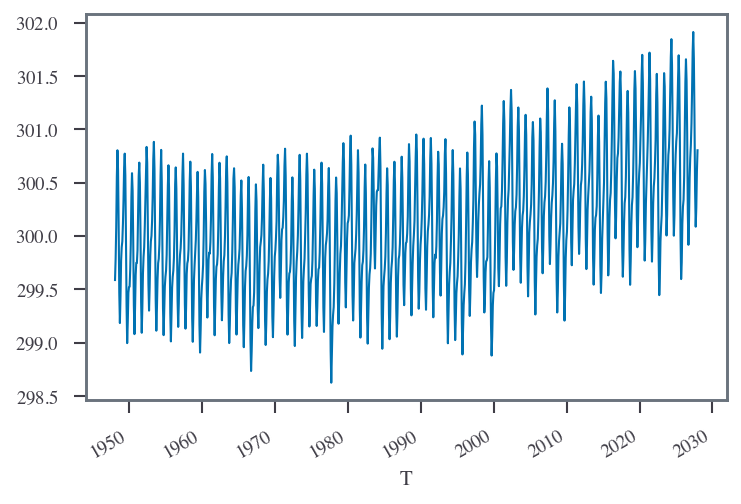

In [11]:
ts_nino34_mean.plot()

In [30]:
ts_nino34_mean_trend = get_trends(ts_nino34_mean)#.sel(T=slice("1958", "2017"))

In [32]:
ts_nino34_ensemble_trend = get_trends(ts_nino34_ensemble)

In [29]:
def get_trends(da: xr.DataArray, beginning=2007, finish=2017) -> xr.Dataset:
    da_tr_list = []
    for start, end in [(str(x - 59), str(x)) for x in range(beginning, finish+1)]:
        da_tr_list.append(
            get_trend(da.sel(T=slice(start, end)), keep_ds=True).expand_dims({"end_year": [int(end)]})
        )
    da_tr = xr.merge(da_tr_list)
    da_tr.end_year.attrs["long_name"] = "End year"
    da_tr.rise.attrs["units"] = "K"
    da_tr.rise.attrs["long_name"] = "Trend over 60 years up to end year"
    return da_tr

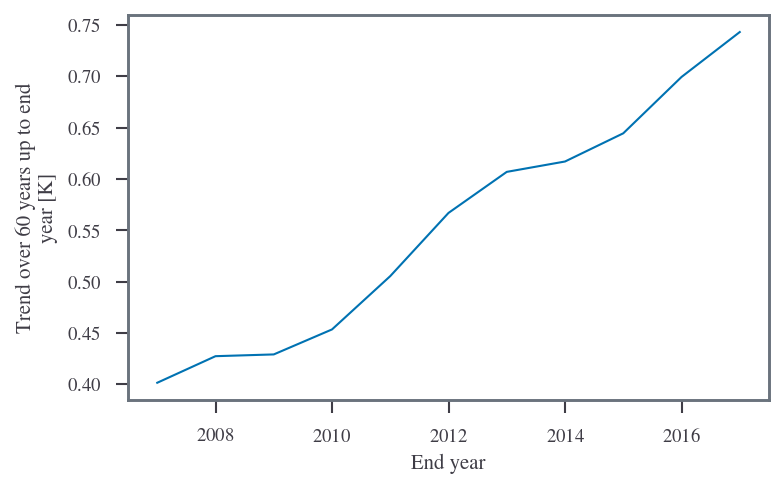

In [31]:
ts_nino34_trend.rise.plot()

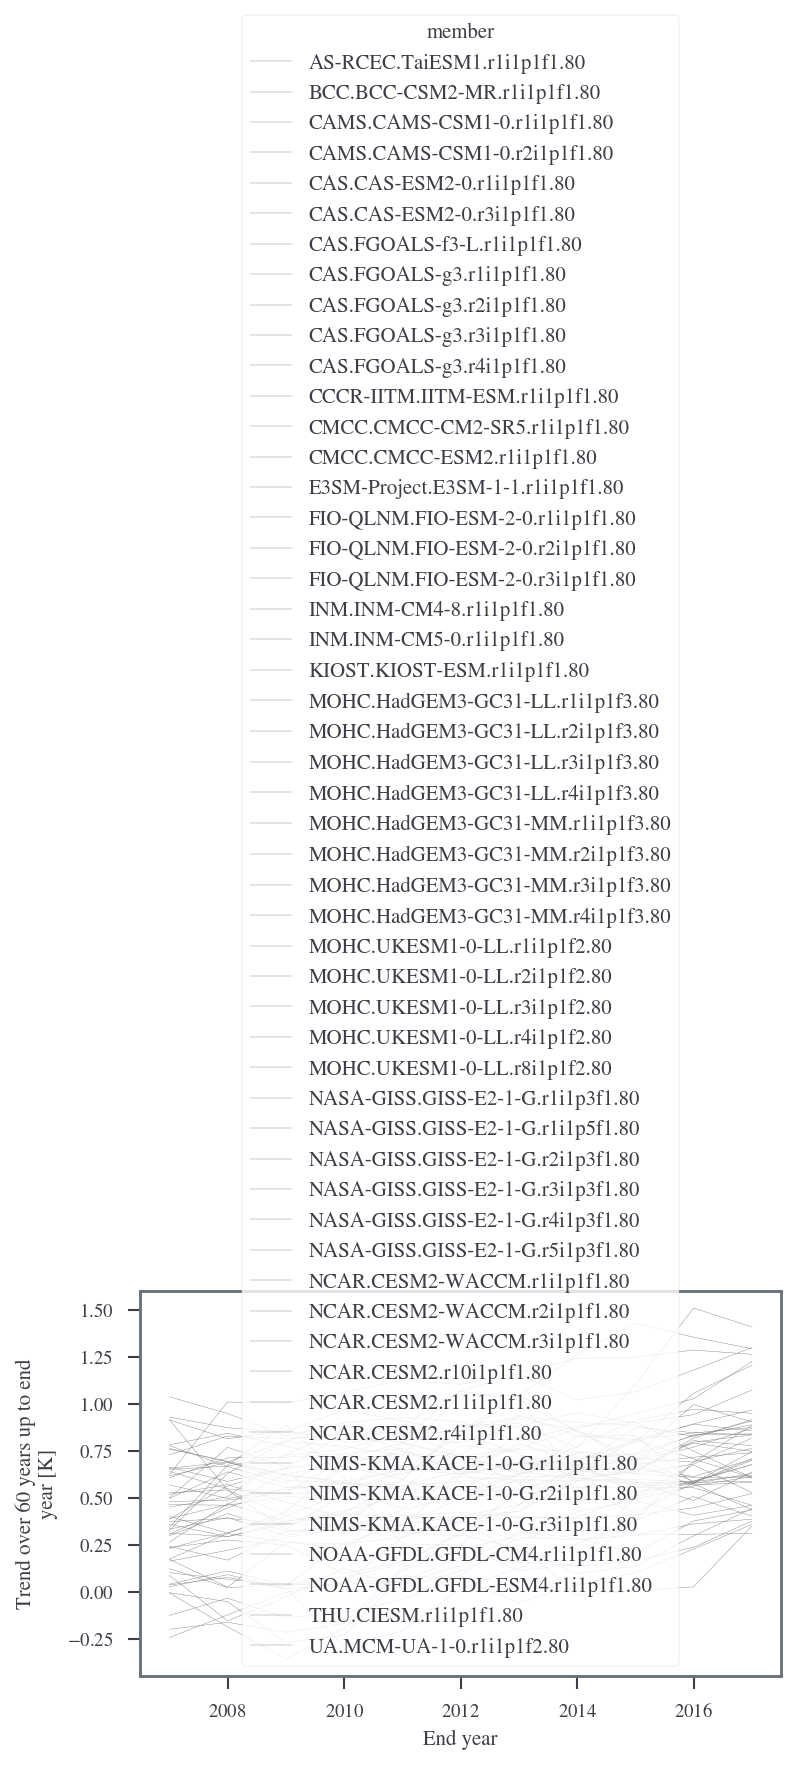

In [70]:
ts_nino34_ensemble_trend.rise.plot.line(hue="member", color="grey", linewidth=0.2)

In [29]:
# da_tr_ensemble = get_trends(ts_ensemble)

In [72]:
ts_tr_mean = get_trends(ts_ensemble.mean("member"), beginning=2016, finish=2017).compute()

In [73]:
ts_tr_mean.rise.attrs["units"] = "$\Delta$K"
ts_tr_mean.rise.attrs["long_name"] = "$T_s$ Trend bias"

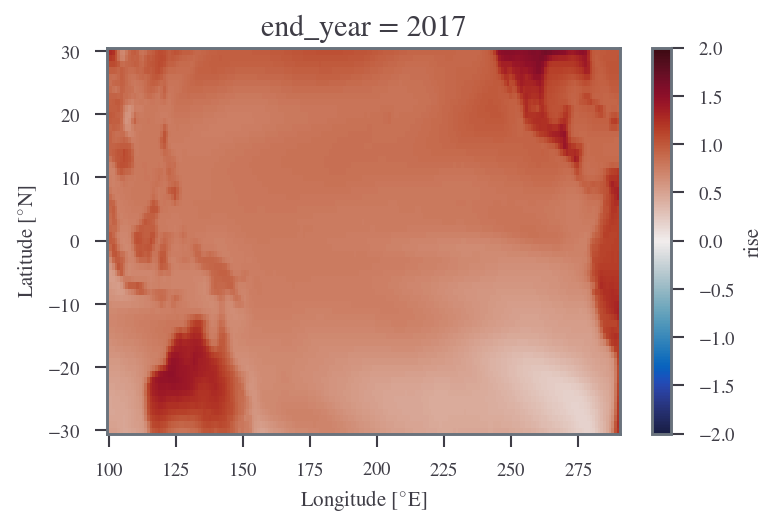

In [31]:
ts_tr_mean.isel(end_year=1).rise.plot(cmap="cmo.balance", vmin=-2, vmax=2)

In [38]:
rh_mmm = sel(
    can_coords(xr.open_mfdataset(cmip6_ensemble_var("hur") + "/*.nc")).hur, reg="pac"
).sel(T=slice("1958", "2017")).mean("T").mean("member").compute()

warning, not changing:  member


/home/users/sithom/seager19/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [62]:
sfcWind_mmm = sel(
    can_coords(xr.open_mfdataset(cmip6_ensemble_var("hur") + "/*.nc")).hur, reg="pac"
).sel(T=slice("1958", "2017"))

warning, not changing:  member


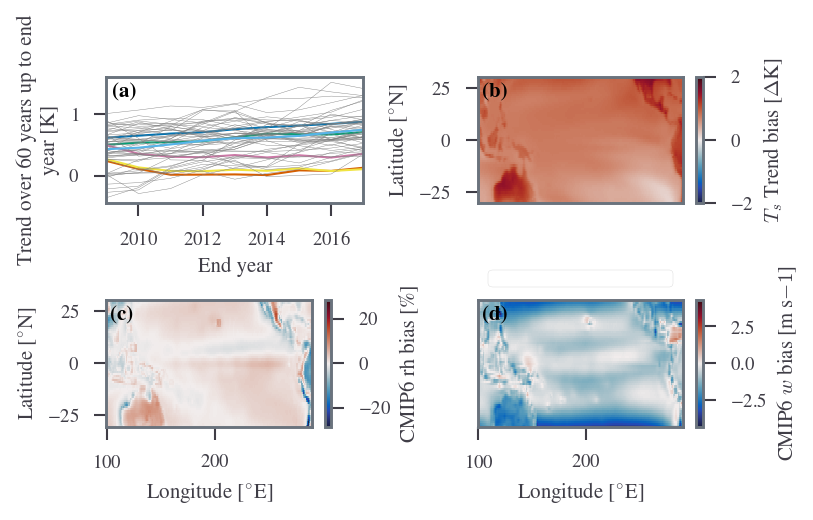

In [78]:
fig, axs = plt.subplots(2, 2)
da = xr.open_dataarray("temp.nc")
ts_trend_labels = da.plot.line(ax=axs[0,0], hue="source")
ts_nino34_ensemble_trend.rise.plot.line(ax=axs[0,0], hue="member", color="grey", linewidth=0.2)
ts_nino34_trend.rise.plot(ax=axs[0,0])
axs[0,0].set_xlim(2009, 2017)
ts_tr_mean.isel(end_year=1).rise.plot(ax=axs[0,1], cmap="cmo.balance", vmin=-2, vmax=2)
axs[0,1].set_title("")
axs[0,1].set_xlabel("")
axs[0,1].set_xticks([])
#da_tr_mean.isel(end_year=1).rise.plot(ax=axs[0,1], cmap="cmo.balance", vmin=-2, vmax=2)
add_units(bias_rh).plot(ax=axs[1,0], cmap="cmo.balance") #, vmin=0, vmax=100)
add_units(bias_wsp).plot(ax=axs[1,1], cmap="cmo.balance") # , vmin=0, vmax=100)
axs[1,1].set_yticks([])
axs[1,1].set_ylabel("")
axs[0,0].get_legend().remove()
label_subplots(axs)
plt.legend(
    ts_trend_labels,
    bbox_to_anchor=(-0, 1.02, 1, 0.102),
    loc="lower left",
    mode="expand",
    ncol=2,
)
plt.tight_layout()

In [40]:
rh_mmm

<xarray.DataArray 'hur' (Y: 61, X: 191)>
array([[76.40787 , 76.27606 , 76.13373 , ...,       inf,       inf,
              inf],
       [76.01028 , 75.87965 , 75.7559  , ...,       inf,       inf,
              inf],
       [75.722725, 75.60333 , 75.50637 , ...,       inf,       inf,
              inf],
       ...,
       [      inf,       inf,       inf, ..., 78.12672 , 78.395584,
        78.58054 ],
       [      inf,       inf,       inf, ..., 77.77023 , 78.08242 ,
        78.32322 ],
       [      inf,       inf,       inf, ..., 77.2506  , 77.60309 ,
        77.90891 ]], dtype=float32)
Coordinates:
    lat      (Y, X) float64 -30.0 -30.0 -30.0 -30.0 ... 30.0 30.0 30.0 30.0
  * X        (X) int64 100 101 102 103 104 105 106 ... 285 286 287 288 289 290
  * Y        (Y) int64 -30 -29 -28 -27 -26 -25 -24 -23 ... 24 25 26 27 28 29 30

In [40]:
from src.constants import atmos_input_file_path

In [58]:
def get_pac(var="ts", model="E"):
    return sel(
        can_coords(xr.open_dataarray(atmos_input_file_path(var=var, model=model))),
        reg="pac",
    )

In [50]:
bias_ts = get_pac(var="ts", model="S") - get_pac(var="ts", model="E")
bias_ts.attrs["units"] = "$\Delta$ K"
bias_ts.attrs["long_name"] = "CMIP6 $T_s$ bias"

In [53]:
bias_wsp = get_pac(var="sfcWind", model="S") - get_pac(var="sfcWind", model="E")
bias_wsp.attrs["units"] = "m s$-1$"
bias_wsp.attrs["long_name"] = "CMIP6 $w$ bias"

In [59]:
bias_rh = get_pac(var="rh", model="S") - get_pac(var="rh", model="E")
bias_rh.attrs["units"] = "%"
bias_rh.attrs["long_name"] = "CMIP6 rh bias"

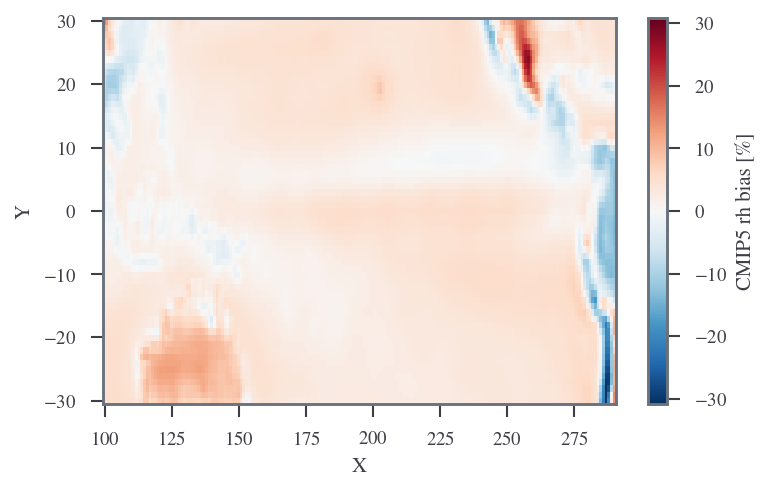

In [80]:
bias_rhC = get_pac(var="rh", model="C") - get_pac(var="rh", model="E")
bias_rhC.attrs["units"] = "%"
bias_rhC.attrs["long_name"] = "CMIP5 rh bias"
bias_rhC.plot()

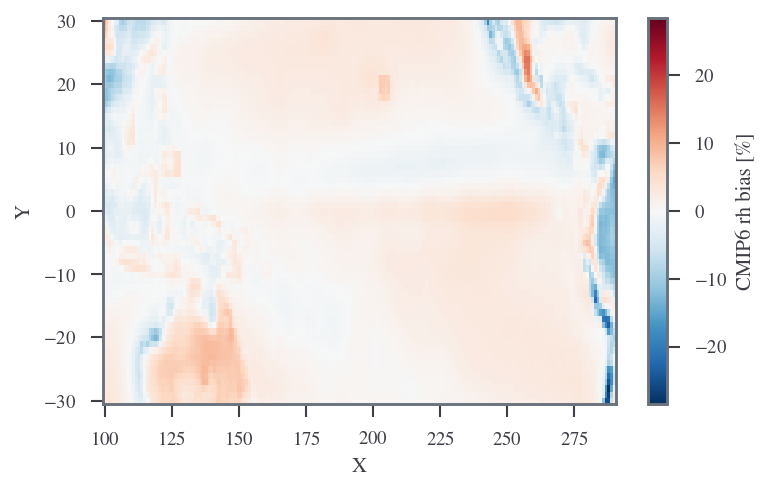

In [60]:
bias_rh.plot()

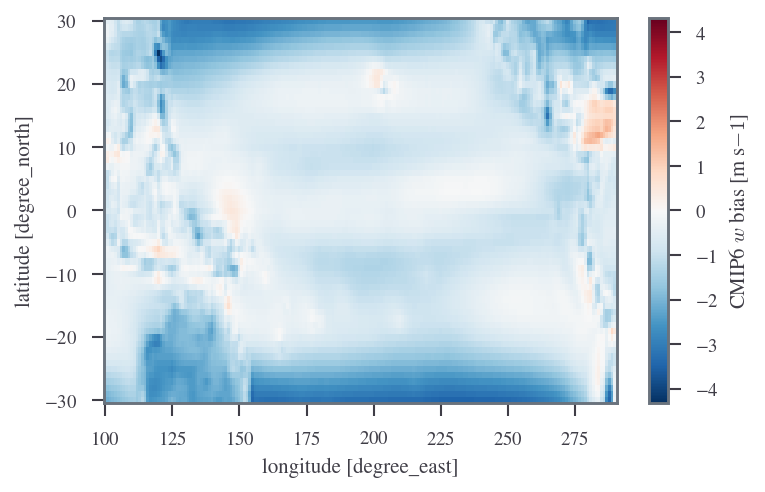

In [54]:
bias_wsp.plot()

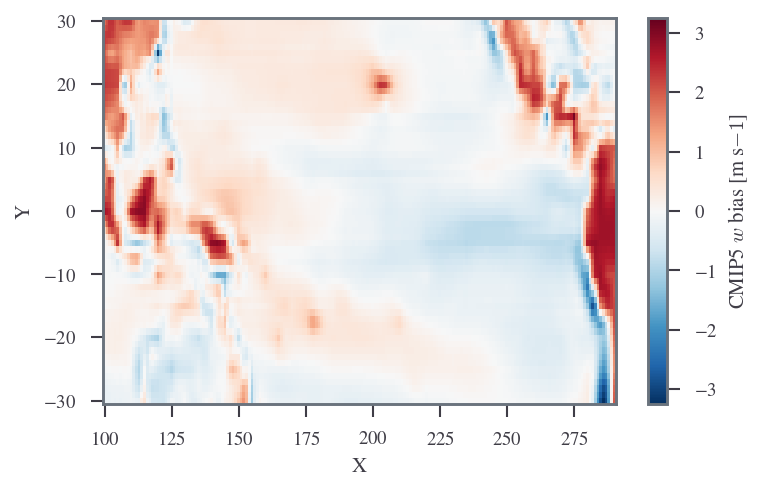

In [79]:
bias_wsp = get_pac(var="sfcWind", model="C") - get_pac(var="sfcWind", model="E")
bias_wsp.attrs["units"] = "m s$-1$"
bias_wsp.attrs["long_name"] = "CMIP5 $w$ bias"
bias_wsp.plot()

In [44]:
xr.open_dataarray(atmos_input_file_path(model="S"))

<xarray.DataArray 'ts' (Y: 181, X: 360)>
array([[271.39435, 271.3733 , 271.3733 , ..., 271.42206, 271.42206, 271.41873],
       [271.39435, 271.3733 , 271.3733 , ..., 271.42206, 271.42206, 271.41873],
       [271.39435, 271.3733 , 271.3733 , ..., 271.42206, 271.42206, 271.41873],
       ...,
       [271.40546, 271.40454, 271.40366, ..., 271.40817, 271.40726, 271.40634],
       [271.41605, 271.4157 , 271.4154 , ..., 271.41705, 271.4167 , 271.41638],
       [271.42194, 271.42184, 271.42178, ..., 271.42218, 271.4221 , 271.42203]],
      dtype=float32)
Coordinates:
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    _CoordinateAxes:     time depth lat lon
    file_missing_value:  -999
    _Fillvalue:          9.96921e+36
    units:               degree_Celsius
    associate:           time depth lat lon
    coordinates:         time depth lat lon
    standard_name:       sea_water_potential_temperature
    offline_operation:   time average and spatial interpolation
    dodsname:            sst
    interval_write:      monthly
    longname:            ts
    long_name:           ts

In [43]:
ls /home/users/sithom/seager19/atmos/DATA/

clt-CMIP6-clim60.nc  rh-CMIP6-clim60.nc       sfcWind-ECMWF-clim.nc
clt-ECMWF-clim60.nc  rh-ECMWF-clim60.nc       sst-ECMWF-clim.nc
mask-360x180.nc      rh-fixed-clim60.nc       sst-ECMWF-trend.nc
mask-360x181.nc      sfcWind-CMIP5-clim60.nc  ts-CMIP6-clim60.nc
pr-ECMWF-clim.nc     sfcWind-CMIP5-clim.nc    ts-CMIP6-clim.nc
pr-ECMWF-trend.nc    sfcWind-CMIP6-clim60.nc  ts-ECMWF-clim60.nc
ps-ECMWF-clim.nc     sfcWind-CMIP6-clim.nc    ts-ECMWF-clim.nc
rh-CMIP5-clim60.nc   sfcWind-ECMWF-clim60.nc  ts-ECMWF-trend.nc
